In [1]:
import os

base_dir = ''
train_images_dir = os.path.join(base_dir, 'train_v2/train')
validation_images_dir = os.path.join(base_dir, 'validation_v2/validation')
test_images_dir = os.path.join(base_dir, 'test_v2/test')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

2024-04-17 15:14:33.329642: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 15:14:34.072630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 15:14:34.072706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 15:14:34.173863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 15:14:34.336514: I tensorflow/core/platform/cpu_feature_guar

In [3]:
train_csv = pd.read_csv(os.path.join(base_dir, 'written_name_train_v2.csv'))
validation_csv = pd.read_csv(os.path.join(base_dir, 'written_name_validation_v2.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'written_name_test_v2.csv'))

In [4]:
# Дропаем все пустые значения
train_csv = train_csv.dropna()

validation_csv = validation_csv.dropna()

test_csv = test_csv.dropna()

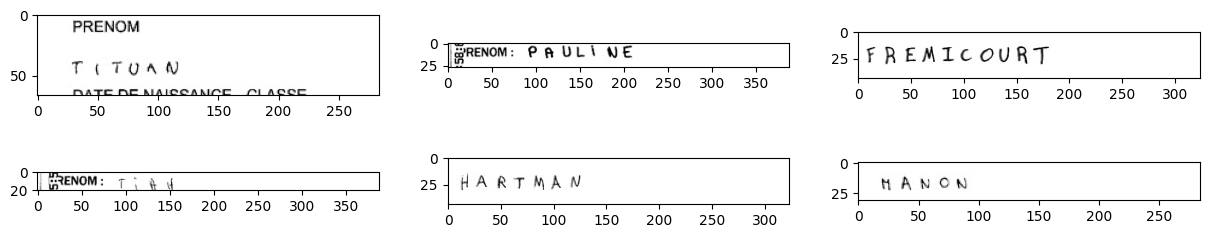

In [5]:
# Семплы, которые нечитаемые
unreadable_indexes = train_csv[train_csv['IDENTITY'] == 'UNREADABLE'].index

plt.figure(figsize = (15,3))

offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i + offset],0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

In [6]:
rain_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']

validation_csv = validation_csv[validation_csv['IDENTITY'] != 'UNREADABLE']

test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

In [7]:
# Сделаем все буквы строчными
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
validation_csv['IDENTITY'] = validation_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of samples found: ", len(train_csv.values))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of samples found:  330396
Number of unique characters:  30
Characters present:  {'a', 'j', 'q', 'x', 'i', 'h', 'b', 'p', 'l', 'f', 'd', '`', "'", 'o', 's', 't', ' ', 'k', 'g', 'v', 'y', 'u', 'w', 'm', '-', 'r', 'z', 'n', 'e', 'c'}


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

sample_sequence = tokenizer.texts_to_sequences(['sample text'])
sample_pad = pad_sequences(sample_sequence, maxlen = max_length, padding = 'post')
sample_text = tokenizer.sequences_to_texts(sample_sequence)
print("Sample sequence: ", sample_sequence[0])
print("Sample pad: ", sample_pad[0])
print("Sample text: ", sample_text[0])

img_width = 50
img_height = 200

Sample sequence:  [10, 2, 11, 18, 5, 1, 25, 8, 1, 24, 8]
Sample pad:  [10  2 11 18  5  1 25  8  1 24  8  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Sample text:  s a m p l e   t e x t


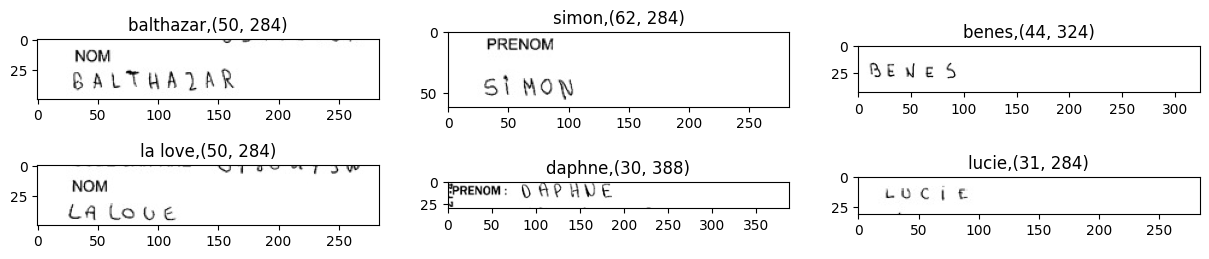

In [9]:
plt.figure(figsize = (15,3))

offset = 0
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[i + offset,0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')
    plt.title(f'{train_csv.iloc[i + offset,1]},{image.shape}')

In [10]:
images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(validation_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255
    
    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,label

In [11]:
train_length = 30000
validation_length = 3000
test_length = 3000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [12]:
x_train = []
y_train = []
train_label_len = []
for i in range(train_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

In [13]:
x_val = []
y_val = []
valid_label_len = []

for i in range(train_length, train_length+validation_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

In [14]:
x_test = []
y_test = []

for i in range(test_length):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]
    
    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([validation_length, 1]) * 48
valid_output = np.zeros([validation_length])

In [16]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [17]:
# Входы в модель
input_img = layers.Input(shape=(200, 50, 1), name="image")
labels = layers.Input(name="label", shape=(max_length,))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv1",)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)


x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv2",)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

x = layers.Reshape(target_shape=(50,768), name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)


x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

# Выходной слой нейронов
y_pred = layers.Dense(len(characters) + 1, activation="softmax", name="output")(x)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])


# Определение модели
model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], 
                           outputs=loss_out,
                           name="ocr_model_v1")

2024-04-17 15:15:08.642943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 15:15:08.912982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 15:15:08.913034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 15:15:08.918721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 15:15:08.918786: I external/local_xla/xla/stream_executor

In [18]:
opt = keras.optimizers.Adam()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

                                                                                                  
 dense1 (Dense)              (None, 50, 64)               49216     ['reshape[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 50, 64)               0         ['dense1[0][0]']              
                                                                                                  
 bidirectional (Bidirection  (None, 50, 512)              657408    ['dropout[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 50, 512)              1574912   ['bidirectional[0][0]']       
 onal)                                                                                            
          

In [19]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [24]:
epochs = 40
early_stopping_patience = 5
# Остановка при отсутсвии положительных изменений
early_stopping = EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)
# Сохранение успешной модели
checkpoint = ModelCheckpoint("model.h5",monitor="val_loss",verbose=1,save_best_only=True,save_weights_only=False,period=1)

# Обучение модели
history = model.fit(
    x = (x_train, y_train, train_input_len, train_label_len),
    y = np.zeros([train_length]),
    validation_data = ([x_val, y_val, valid_input_len, valid_label_len], np.zeros([validation_length]) ),
    epochs=epochs,
    batch_size = 25,
    callbacks=[checkpoint, early_stopping])

In [21]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

94/94 [==============================] - 4s 23ms/step


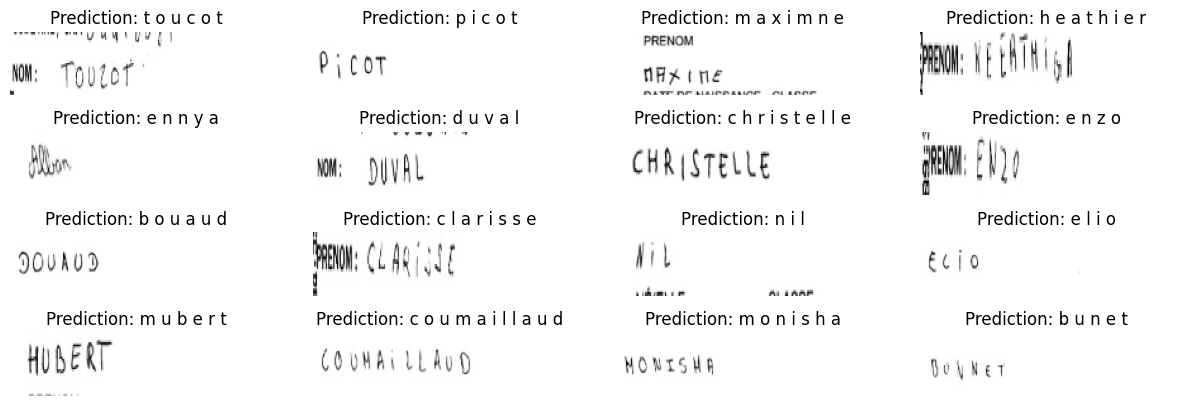

In [22]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)

_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
model.save("my_model.keras")

/home/kot/.local/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:403: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


# Загрузка обученной модели из файла
loaded_model = tf.keras.models.load_model('my_model.keras')

# Теперь вы можете использовать загруженную модель для предсказаний
predictions = loaded_model.predict(X_test)